### Laboratorium 6 - część 2/2

W tej części zajmiesz się wykorzystaniem punktów kluczowych do dwóch popularnych zadań: wyszukiwania obszarów podobnych oraz łączenia obrazów (_image stitching_).

Przeczytaj treść całej instrukcji przed przystąpieniem do działania!

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#### Zadanie 3

Dane są obrazy `coke` i `table`. Wykorzystaj metodologię parowania punktów kluczowych do znalezienia wystąpienia puszki z Colą na stole. To zadanie jest podzielone na kilka kamieni milowych - czytaj dalej.

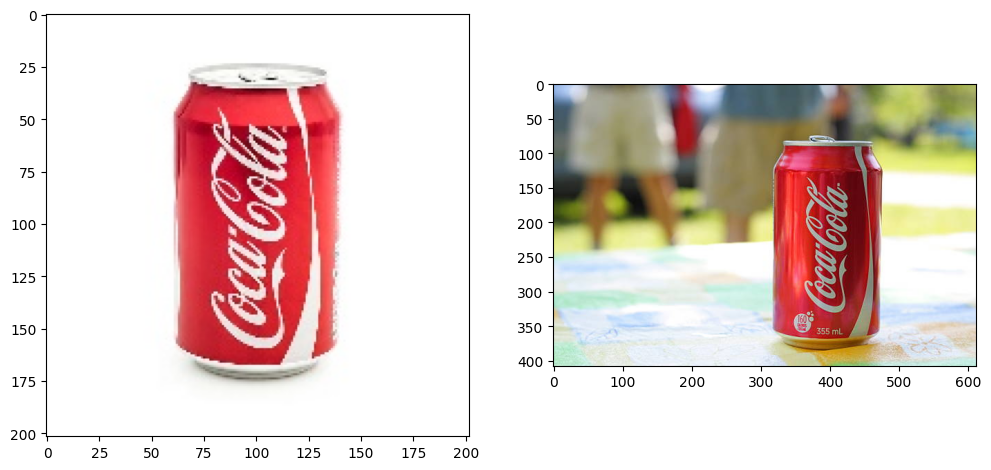

In [2]:
coke = cv2.imread('data/coke.jpg')
table = cv2.imread('data/coke-table.jpg')
f, (a1, a2) = plt.subplots(1, 2, figsize=(12,12))
a1.imshow(coke[..., ::-1])
a2.imshow(table[..., ::-1])

##### Zadanie 3a

Wykonaj detekcję punktów kluczowych i ich parowanie z użyciem dowolnego matchera. Wykonaj filtrację znalezionych par po dystansie - co obserwujesz, zmieniając próg?

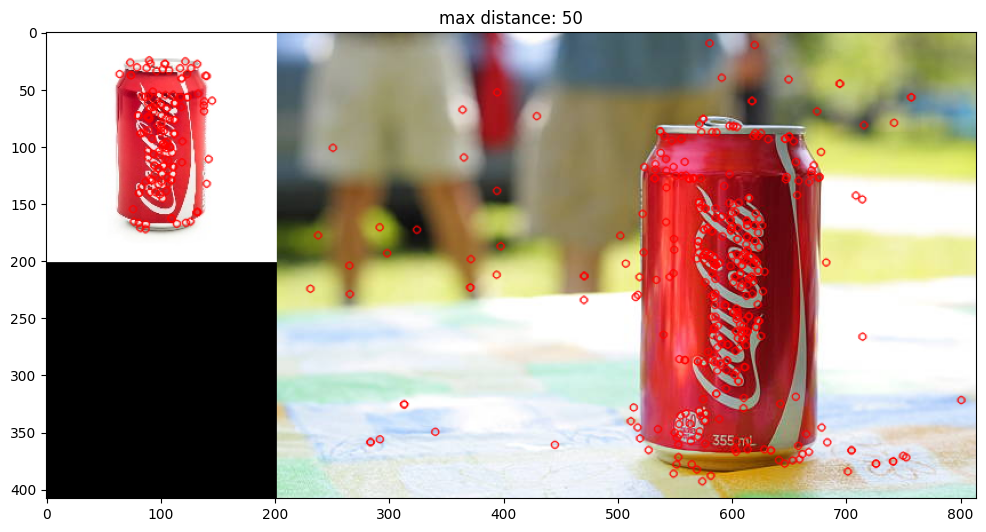

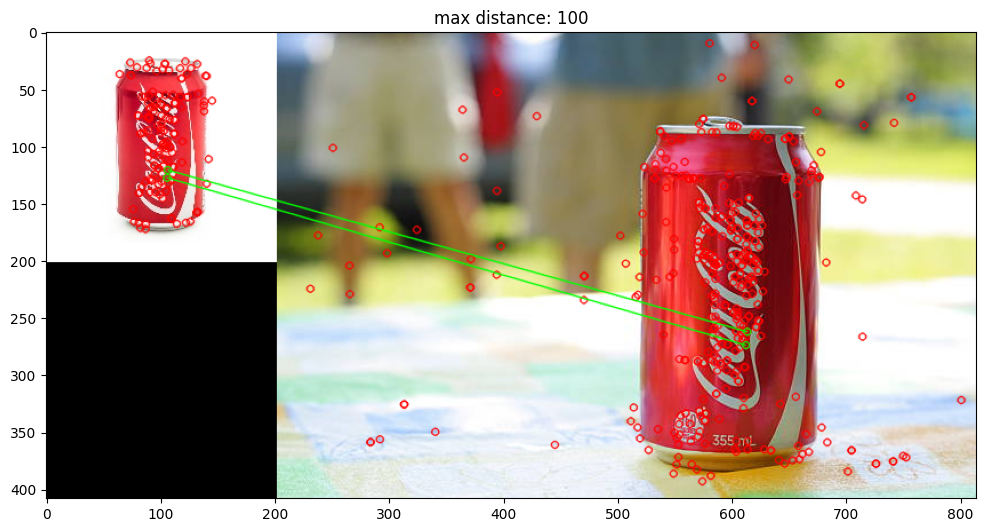

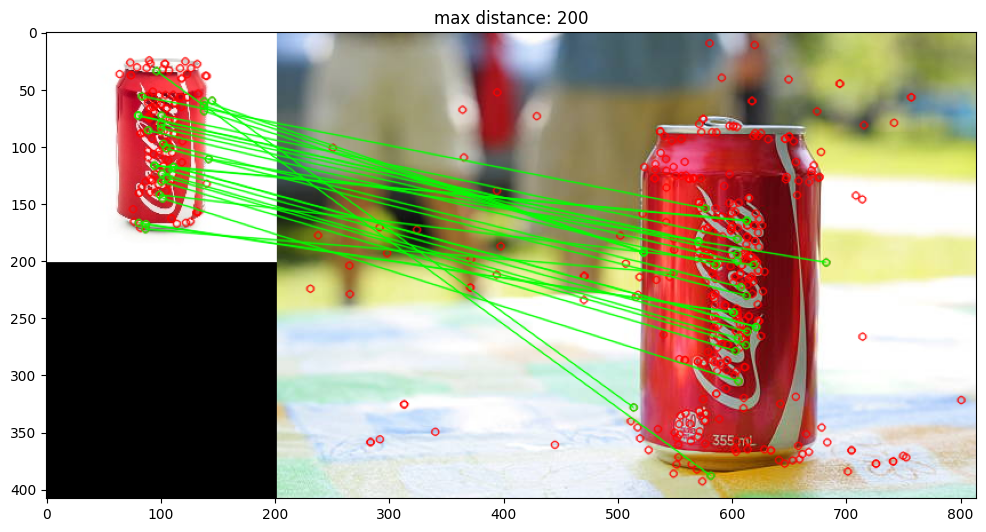

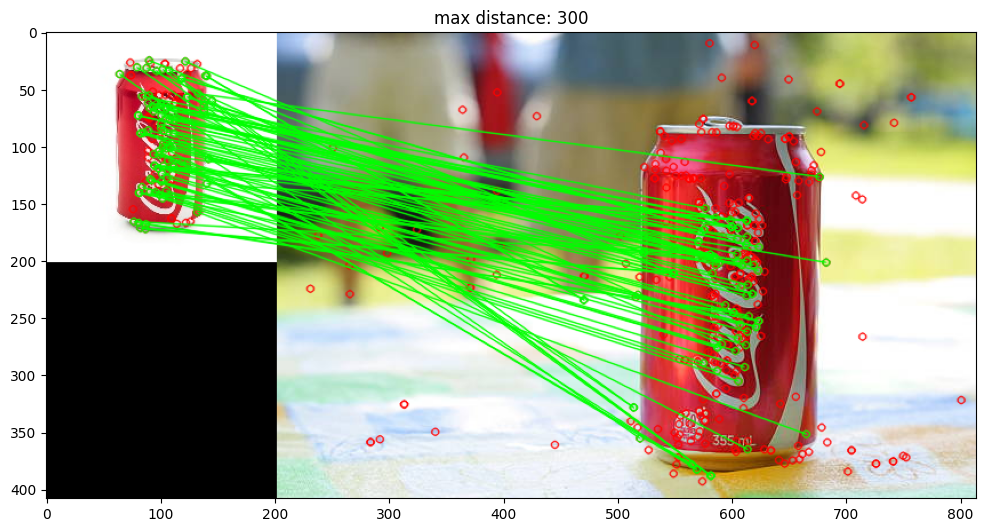

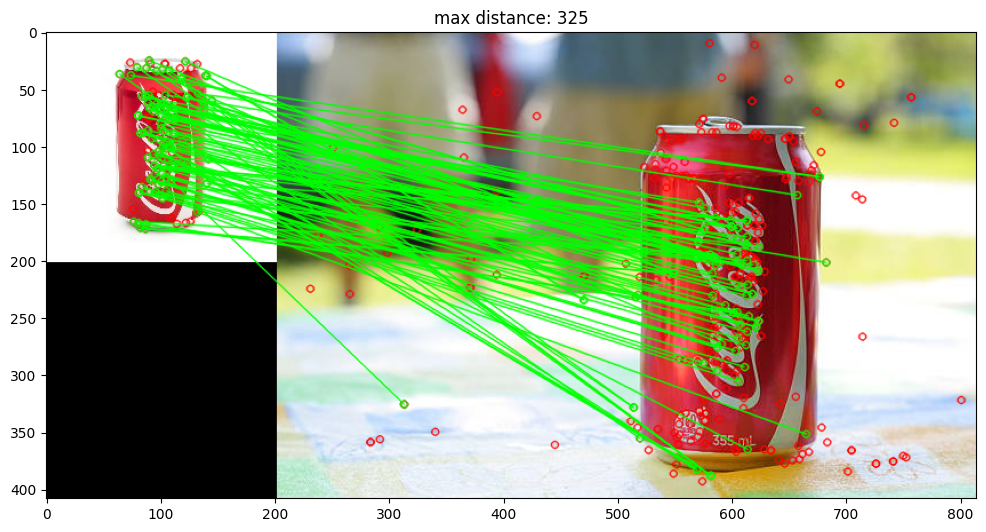

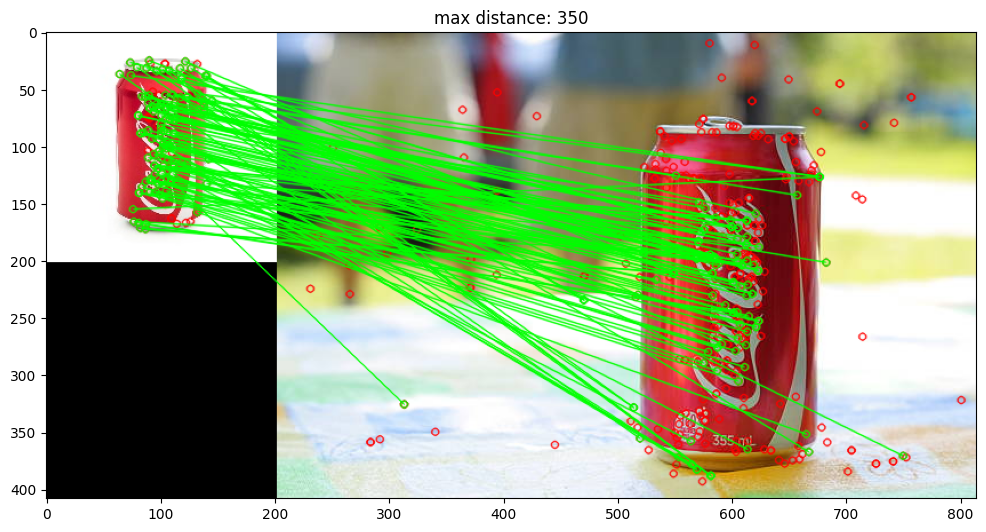

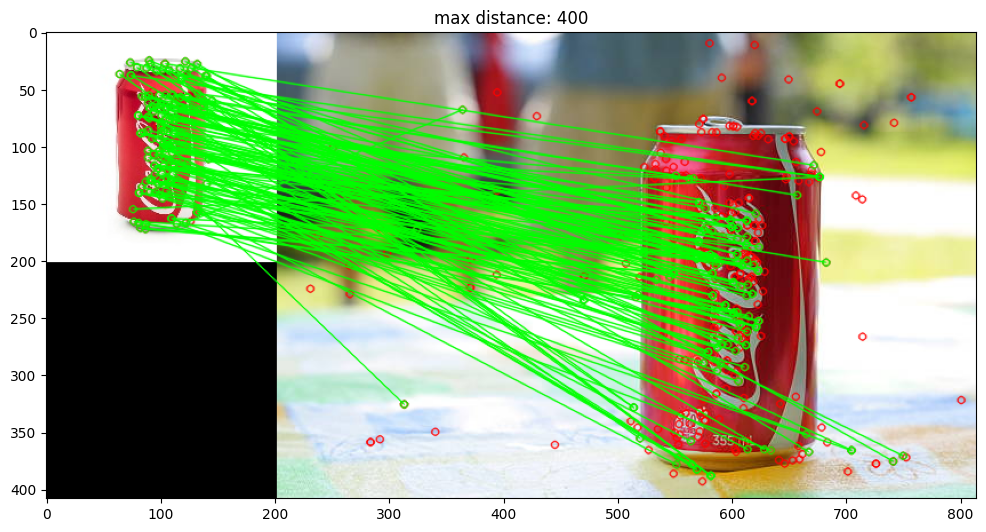

In [133]:
def match_points(dist_threshold):
    sift = cv2.SIFT_create(edgeThreshold=15)
    coke_kps, coke_ds = sift.detectAndCompute(coke, None)
    table_kps, table_ds = sift.detectAndCompute(table, None)
    matcher = cv2.BFMatcher_create()
    best_matches = matcher.match(coke_ds, table_ds)
    best_matches = list(filter(lambda match: match.distance < dist_threshold, best_matches))
    show_matches = cv2.drawMatches(coke, coke_kps, table, table_kps, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
    plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1])
    plt.title(f'max distance: {dist_threshold}')
    plt.show()

for distance in [50, 100, 200, 300, 325, 350, 400]:
    match_points(dist_threshold=distance)

##### Zadanie 3b

Powtórz detekcję z użyciem k-najlepszych wyników (dla niewielkiego k, np. 2 lub 3). Zaproponuj prosty sposób wykrywania sytuacji, w których jeden punkt jest podobnie bliski innym i użyj go do odfiltrowania wyników, tak aby pozostawić te bardziej unikatowe dopasowania. *Czy unikatowe znaczy dobre?*

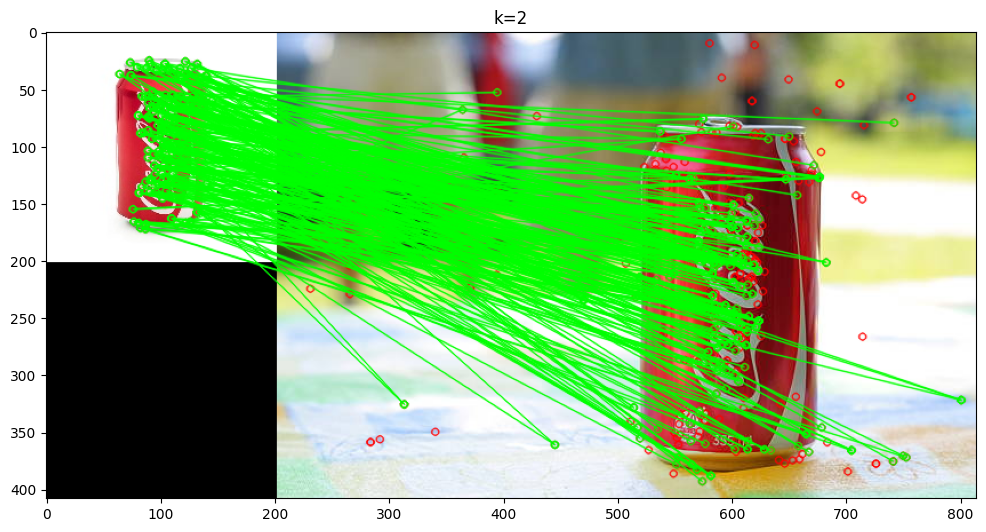

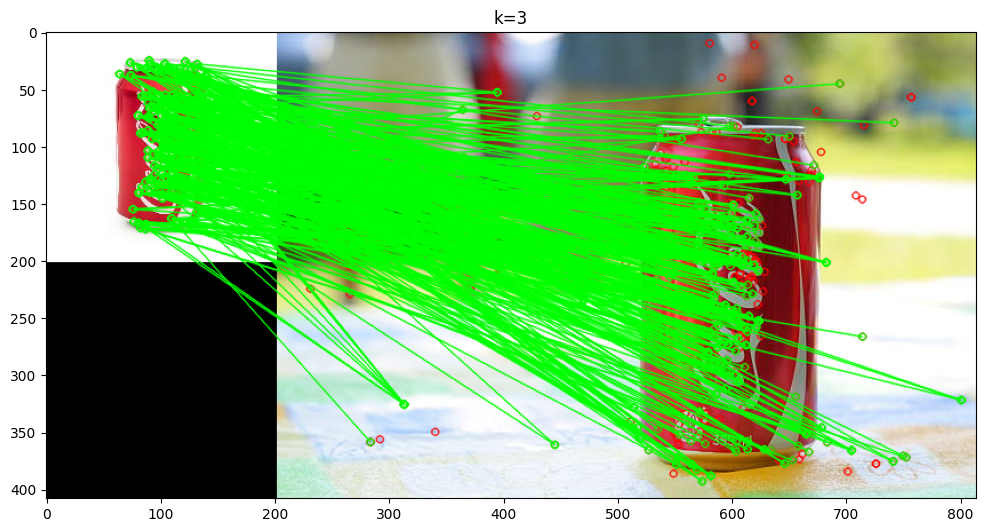

In [134]:
def match_points_knn(k):
    sift = cv2.SIFT_create(edgeThreshold=15)
    coke_kps, coke_ds = sift.detectAndCompute(coke, None)
    table_kps, table_ds = sift.detectAndCompute(table, None)
    matcher = cv2.BFMatcher_create()
    best_matches = matcher.knnMatch(coke_ds, table_ds, k=k)
    show_matches = cv2.drawMatchesKnn(coke, coke_kps, table, table_kps, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
    plt.subplots(1, 1, figsize=(12,12))[1].imshow(show_matches[...,::-1])
    plt.title(f'k={k}')
    plt.show()

match_points_knn(k=2)
match_points_knn(k=3)

##### Zadanie 3c

Znajdź transformację geometryczną dla par dopasowanych punktów, tak aby przekształcić `coke` (*train*) do geometrii `table` (query). Zademonstruj poprawność, zestawiając obok siebie przekształconą wersję `coke` oraz oryginalny `table`, bądź nanosząc jedno na drugie. Zidentyfikuj punkty, które znaleziona transformacja przekształca "dobrze", tzn. ich współrzędne po przekształceniu leżą w pobliżu odpowiadających im punktów z drugiego obrazu; nanieś je na obraz.

*Jak na wyniki wpływa wykrycie większej lub mniejszej liczby punktów kluczowych na etapie SIFT? W jakim stopniu wstępna filtracja poprawia rezultaty? Jak działa i jaką rolę w procesie parowania odgrywa RANSAC?*

*\"Na piątkę\"*: znajdź rejon zainteresowania (RoI), tj. prostokąt otaczający zidentyfikowane właśnie punkty, a następnie oblicz błąd średniokwadratowy między obrazami w tym rejonie (albo dowolną miarę podobieństwa). Bonus: użyj [`cv2.convexHull`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) do narysowania maski wybierającej tylko piksele znajdujące się wewnątrz wielokąta otaczającego "dobrze" dopasowane punkty, by liczyć miarę podobieństwa jedynie wewnątrz tego obszaru.

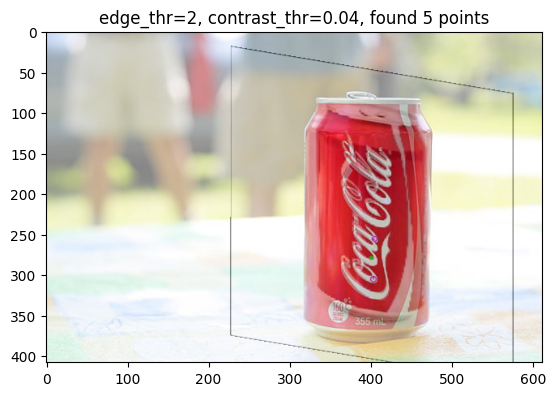

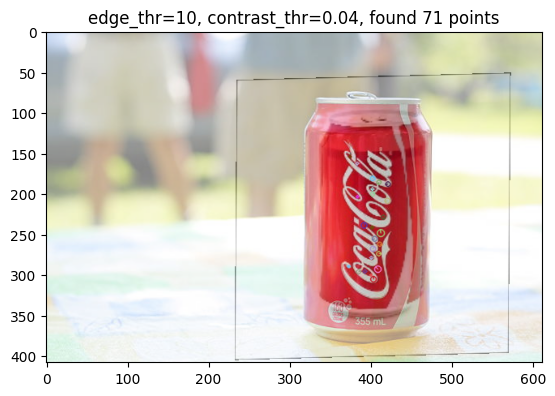

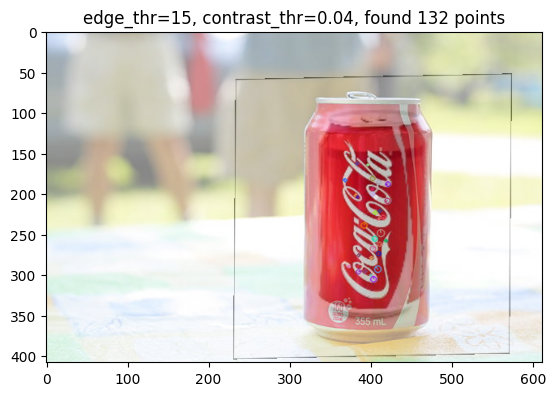

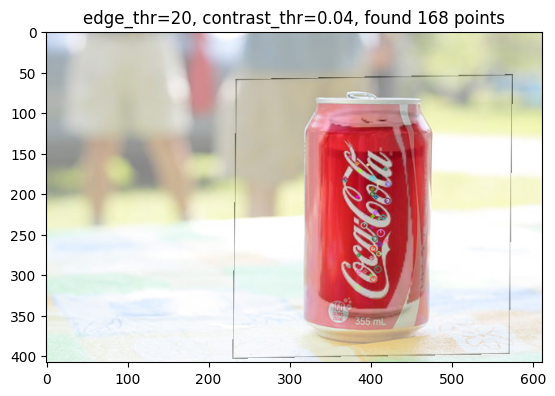

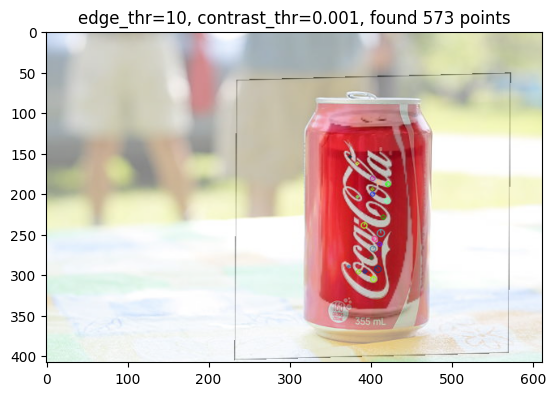

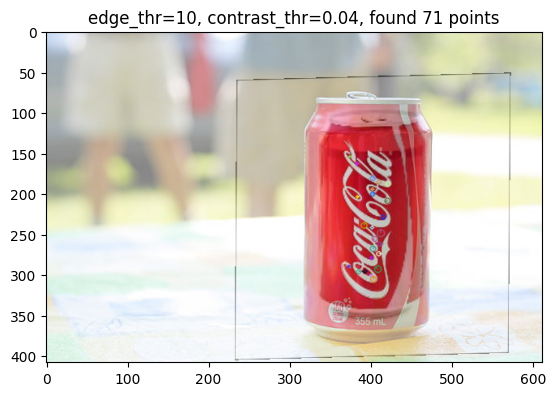

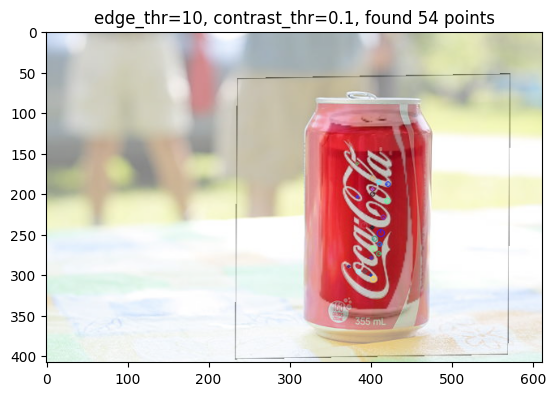

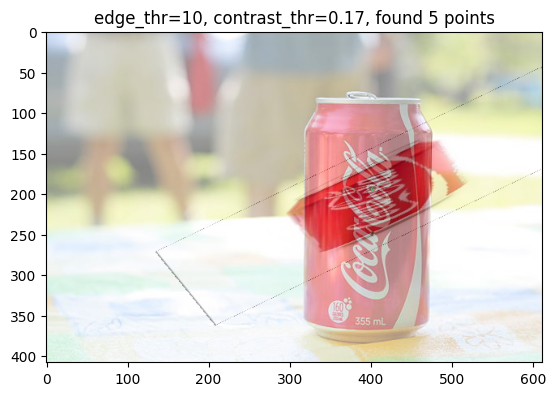

In [199]:
def move_coke(threshold = 300, edge_thr = 10, contrast_thr = .04):
    sift = cv2.SIFT_create(edgeThreshold=edge_thr, contrastThreshold=contrast_thr)
    coke_kps, coke_ds = sift.detectAndCompute(coke, None)
    table_kps, table_ds = sift.detectAndCompute(table, None)
    matcher = cv2.BFMatcher_create()
    best_matches = matcher.match(table_ds, coke_ds)
    best_matches = list(filter(lambda match: match.distance < threshold, best_matches))

    train_pts = np.array([coke_kps[idx.trainIdx].pt for idx in best_matches])
    query_pts = np.array([table_kps[idx.queryIdx].pt for idx in best_matches])
    query_key_points = np.array([table_kps[idx.queryIdx] for idx in best_matches])

    warp_mat, is_inlier = cv2.estimateAffine2D(train_pts, query_pts)
    idx = np.array(is_inlier).astype(bool).squeeze()

    warp_dst = cv2.warpAffine(
    coke, M=warp_mat, dsize=(table.shape[1], table.shape[0]))
    warp_hsv = cv2.cvtColor(warp_dst, cv2.COLOR_BGR2HSV)
    warp_hsv[:,:,1][warp_hsv[:,:,1] == 0] = 0
    warp_hsv[:,:,2][warp_hsv[:,:,2] == 0] = 255
    
    warp_dst = cv2.cvtColor(warp_hsv, cv2.COLOR_HSV2BGR)
    both = cv2.addWeighted(warp_dst, 0.5, table, 0.5, 0.0)
    both = cv2.drawKeypoints(both, query_key_points[idx], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(both[..., ::-1])
    plt.title(f'edge_thr={edge_thr}, contrast_thr={contrast_thr}, found {len(best_matches)} points')
    plt.show()

move_coke(edge_thr=2)
move_coke(edge_thr=10)
move_coke(edge_thr=15)
move_coke(edge_thr=20)

move_coke(contrast_thr=0.001)
move_coke(contrast_thr=0.04)
move_coke(contrast_thr=0.1)
move_coke(contrast_thr=0.17)


#### Zadanie 4

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być zupełnie dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy zawierały jakieś punkty charakterystyczne. (Może posiadasz jakieś ciekawe dane z własnego projektu, które możesz tu wykorzystać?)

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o połowę-2/3 szerokości klatki)
* większe przesunięcie (o 3/4-4/5 szerokości)
* przesunięcie z rotacją w osi kamery
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Celem zadania będzie przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia (_stitching_) obrazów. Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3c) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary tworzonych w ten sposób obrazów są wystarczające do zmieszczenia obu składowych. Jeśli rozwiązujesz zadanie 3c w wariancie _\"na piątkę\"_, użyj tej metody oceny również w tym zadaniu.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jaka jest jakość dopasowania? Jeśli dla którejś pary algorytm zawiódł - dlaczego?*